In [1]:

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import metrics

import scipy.stats as stats
import matplotlib

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [2]:
def pre_processing(df_original, feature_scaling=True):
    #
    # only works for numerical dataframe
    #

    df = df_original.copy()
    df = df.drop(range(0, 10))
    df.index = range(len(df.index))

    df['month_year'] = [str(i[1]) + '-' + str(i[0]) for i in df['date'].astype(str).apply(lambda x: x.split('-'))]

    df = df.drop(['date'], axis=1)

    # handling the missing values
    ########################################################################
    # handle when number of records with missing values are less than 1%
    if (df.isna().sum().sum()) * 100 / len(df) < 1:
        df.dropna(axis=0)

    # handle when entries in column with missing values are less than 50%
    for i in range(len(df.isna().sum())):
        if (df.isna().sum()[i]) * 100 / len(df) > 50:
            df.drop(df.isna().sum().index[i], inplace=True, axis=1)

    # imputation using mean for numerical values
    num_cols = df._get_numeric_data().columns

    for i in range(len(df.isna().sum())):
        if df.isna().sum().index[i] in num_cols:
            df[df.isna().sum().index[i]].fillna(value=df[df.isna().sum().index[i]].mean(), inplace=True, axis=1)

    # return the updated dataframe

    # Feature scaling on numerical data
    ##########################################################################
    #
    if feature_scaling:
        for i in df.columns.tolist():
            if i != 'month_year':
                df[i] = df[i].apply(lambda x: (x - df[i].mean()) / df[i].std())

    return df


def merger(datalist, common_column="month_year", how_param="left", drop_na=True):
    data = datalist[0]
    for i in range(len(datalist) - 1):
        data = pd.merge(data, datalist[i + 1], on=common_column, how=how_param)
    if drop_na:
        data = data.dropna()
    data = data.reset_index()
    data = data.drop("index", axis=1)
    
    return data

# Outlier detection and removal
###########################################################################
#
def DBScan(data, radius=0.3, min_points=10, avoid_col = None):

    X = data.copy()

    if avoid_col is not None:
        X = X.drop(avoid_col, axis=1)

    db = DBSCAN(eps=radius, min_samples=min_points).fit(X)
    core_points = np.zeros_like(db.labels_, dtype=bool)

    core_points[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Number of outliers
    n_noise = list(labels).count(-1)

    try:
        print("Number of clusters formed: ",n_clusters)
        print("Number of outliers(removed): ",n_noise)
        print("Silhouette Coefficient: %0.2f" % metrics.silhouette_score(X, labels))
        s_c = metrics.silhouette_score(X, labels)
        
    except:
        print("Problem in calculating Silhouette.")
        s_c = -1
    # Removing the outliers
    data= data[core_points]
    data = data.reset_index()
    data = data.drop("index", axis=1)
    
    ##############################################################################
    return data, s_c 


def covNcorr(Mat):
    '''
    Data matrix is required in the columns as attributes(features) and rows as records
    '''
    Mat= Mat.astype(np.float)
    r,c= Mat.shape
    Colstd= np.zeros(c).astype(np.float)
    
    for i in range(c):
        Mat.iloc[:,i]= Mat.iloc[:,i]- np.mean(Mat.iloc[:,i])
    for i in range(c):
        Colstd[i]= 1/(r-1) * np.sqrt(np.dot(np.transpose(Mat.iloc[:,i]),Mat.iloc[:,i]))
    CovMat=np.zeros([c,c]).astype(np.float)
    CorrMat=np.zeros([c,c]).astype(np.float)
    for i in range(c):
        for j in range(c):
            CovMat[i][j]= 1/(r-1) * np.dot(np.transpose(Mat.iloc[:,i]),Mat.iloc[:,j])
            CorrMat[i][j]= 1/(r-1) * np.dot(np.transpose(Mat.iloc[:,i]),Mat.iloc[:,j]) / (Colstd[i]*Colstd[j])
    return CovMat, CorrMat

def PCA(Mat, IP=90, PCA_vectors=0, verbose = True):
    CovMat, CorrMat = covNcorr(Mat)
    
    if verbose:
        print('Correlation matrix\n###################################\n')
        print(CorrMat)
    
    e,v= np.linalg.eig(CovMat)
    df= pd.DataFrame([e,v]).transpose()
    df.columns=(["EigenValue","EigenVector"])
    dfsorted=df.sort_values(by= "EigenValue",ascending=False)
    eigenvalues_sorted= np.array(dfsorted["EigenValue"])
    eigenvectors_sorted= np.array(dfsorted["EigenVector"])

    sum_eigenvalues= np.sum(eigenvalues_sorted)
    eigen_temp_sum=0.0
    IP_calc= 0.0
    Transform_matrix= np.transpose(eigenvectors_sorted[0]).copy()
    i=0
    flag=1
    while flag:
        eigen_temp_sum= eigen_temp_sum+ eigenvalues_sorted[i]
        IP_calc= eigen_temp_sum/sum_eigenvalues *100
        if verbose:
            print("Adding Component No.", i+1)
        if i!=0:
            Transform_matrix = np.append(Transform_matrix,np.transpose(eigenvectors_sorted[i]))
        i=i+1
        if verbose:
            print("Information Retained = ", IP_calc)
        if PCA_vectors==0:
            if IP <= IP_calc or IP_calc==100:
                flag=0
        else:
            if i>=PCA_vectors or IP_calc==100:
                flag=0
    Ready_Transform_basis= np.transpose(Transform_matrix.reshape(i,eigenvectors_sorted[0].shape[0])).copy()
    if verbose:
        print(Ready_Transform_basis)
        print("Projected Data:")
    projected_data= np.dot(Mat,Ready_Transform_basis)
    if verbose:
        print(projected_data)

    information_Retained= IP_calc
   
    return Ready_Transform_basis, projected_data, information_Retained


def visualisatio_using_pca(features, target):
    
    Transformation_mat, projected_data, info_retainment = PCA(features,PCA_vectors=1, verbose=True)
    fig = plt.figure()
    fig.set_figwidth(16)
    fig.set_figheight(8)
    
    plt.scatter(projected_data, target, color = 'green')
    plt.title('Visualisation of variance on 1st Principle Component')
    plt.ylabel('GDP')
    plt.xlabel('1st PC projection')
    plt.legend([str(round(info_retainment,2))+"% information of actual data"])
    plt.show()


def polynomial_regressor_fit(X, y, degree=2):

    polynomial_model = PolynomialFeatures(degree=degree)
    transformed_X = polynomial_model.fit_transform(X)
    polynomial_model.fit(transformed_X, y)
    regressor = LinearRegression()
    regressor.fit(transformed_X, y)

    return regressor

In [3]:
#
# Data laoding
#

df_cpi = pd.read_excel("data/CPI_base2015_1960_2020_Monthly.xls", names=['date', 'CPI_value'])
df_export_g_s = pd.read_excel("data/Export_G&S_1996_2020_quart.xls", names=['date', 'Export_g_s_value'])
df_GFCE = pd.read_excel("data/GFCE_1996_2020_quart.xls", names=['date', 'GFCE_value'])
df_GFCF = pd.read_excel("data/GFCF_1996_2020_quart.xls", names=['date', 'GFCF_value'])
df_GDP = pd.read_excel("data/GDP_india_1997_2021.xls", names=['date', 'GDP_value'])
df_M1 = pd.read_excel("data/M1_1969_2020_Monthly.xls", names=['date', 'M1_value'])
df_M3 = pd.read_excel("data/M3_1960_2020_Monthly.xls", names=['date', 'M3_value'])
df_PFCE = pd.read_excel("data/PFCE_1996_2020_quart.xls", names=['date', 'PFCE_value'])

In [4]:
#
#  Pre-processing
#

df_cpi = pre_processing(df_cpi)
df_export_g_s = pre_processing(df_export_g_s)
df_GFCE = pre_processing(df_GFCE)
df_GFCF = pre_processing(df_GFCF)
df_GDP = pre_processing(df_GDP, feature_scaling=False)
df_M1 = pre_processing(df_M1)
df_M3 = pre_processing(df_M3)
df_PFCE = pre_processing(df_PFCE)

In [5]:
#
#  creating a common dataset
#

datalist = [df_cpi, df_export_g_s, df_GFCF, df_GFCE, df_M1, df_M3, df_PFCE, df_GDP]
data = merger(datalist)
data.head(95)


,CPI_value,month_year,Export_g_s_value,GFCF_value,GFCE_value,M1_value,M3_value,PFCE_value,GDP_value
0,-0.107924,04-1997,-1.118469,-1.120248,-0.996790,-0.380329,-0.428011,-1.014680,3.27187
1,-0.098937,07-1997,-1.119222,-1.117364,-0.993116,-0.377237,-0.424291,-1.006179,3.99521
2,-0.083210,10-1997,-1.110665,-1.108893,-0.979392,-0.377156,-0.418694,-1.000421,4.01085
3,-0.040523,01-1998,-1.113908,-1.104725,-0.916516,-0.371136,-0.413276,-0.991115,4.91695
4,-0.042770,04-1998,-1.103360,-1.095099,-0.911770,-0.352962,-0.401016,-0.979275,5.85828
...,...,...,...,...,...,...,...,...,...
90,2.465354,10-2019,1.665878,1.847291,1.734256,2.784139,2.763422,2.087873,3.32467
91,2.517179,01-2020,1.541440,1.837205,1.703967,2.909907,2.843319,2.046024,2.93549
92,2.506814,04-2020,1.054753,0.354731,2.535564,3.130820,3.004737,1.133394,-23.3268
93,2.579368,07-2020,1.603474,1.617637,1.682778,3.332501,3.129132,1.713926,-7.53683


In [6]:
#
#  Anomalies detection on the attributes
#

In [7]:
# Calculating Anomaly using GESD testing 

def calculate_test_stat(y, iteration):
    std_dev = np.std(y)
    avg_y = np.mean(y)
    abs_val_minus_avg = abs(y - avg_y)
    max_of_deviations = max(abs_val_minus_avg)
    max_ind = np.argmax(abs_val_minus_avg)
    cal = max_of_deviations/ std_dev
    return cal, max_ind,y[max_ind]

def calculate_critical_value(size, alpha, iteration):
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
    return critical_value

def GESD(attribute, alpha, frame_of_detection):
    input_series = list(attribute)
    stats = []
    critical_vals = []
    anomily_list_index = []
    for iterations in range(1, frame_of_detection + 1):
        stat, max_index, max_index_value = calculate_test_stat(input_series, iterations)
        critical = calculate_critical_value(len(input_series), alpha, iterations)
        #print("deleting value", max_index_value)
        input_series = np.delete(input_series, max_index)
        
        critical_vals.append(critical)
        stats.append(stat)

        if stat > critical:
            max_i = iterations
            anomily_list_index.append(attribute.index(max_index_value))
        
    
    return anomily_list_index

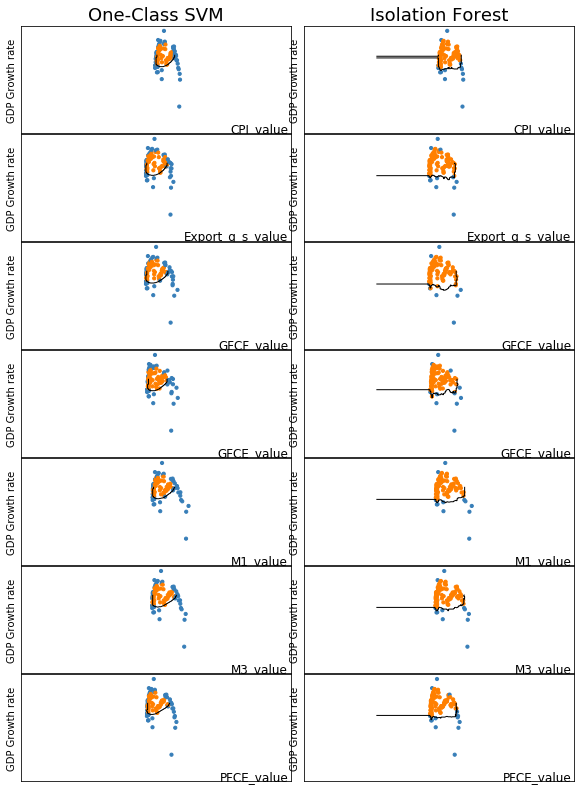

In [8]:
tempdata = data.copy()
tempdata = tempdata.drop("month_year", axis = 1)
attribute_names = tempdata.columns.to_list()
matplotlib.rcParams["contour.negative_linestyle"] = "solid"


anomaly_algorithms = [
    ("One-Class SVM", svm.OneClassSVM(kernel="rbf", gamma=0.2)),
    ("Isolation Forest", IsolationForest(random_state=42),),
]

datasets = []
for attri in tempdata.columns.to_list():
    dataset =[]
    for k in range(len(tempdata[attri])):
        # creating dataset as a list of list = [[1st_value_of_attrib, 1st_value_of_GDP], [2nd_value_of_attrib, 2nd_value_of_GDP],.....]
        dataset.append([tempdata[attri].to_list()[k],tempdata["GDP_value"].to_list()[k]])
    # appending dataset  on datasets
    datasets.append(np.array(dataset))

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)
nm = 0
for i_dataset, X in enumerate(datasets):
    if attribute_names[nm]== "GDP_value":
        break
    for name, algorithm in anomaly_algorithms:
        algorithm.fit(X)
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        
        y_pred = algorithm.fit(X).predict(X)

        Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels=[0], linewidths=1, colors="black")
        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])
        plt.xlim(-15, 15)
        plt.ylim(-15, 15)
        plt.xticks(())
        plt.yticks(())
        plt.ylabel("GDP Growth rate")
        plt.text(
            0.99,
            0.01,
            attribute_names[nm],
            transform=plt.gca().transAxes,
            size=12,
            horizontalalignment="right",
        )
        plot_num += 1
    nm+=1

plt.show()

In [9]:
anomaly ={}
for i in data.columns.to_list():
    #checking the anomalies column by column
    if i != "month_year":
        columns_value = data[i].to_list()

        anom_index_list = GESD(columns_value, alpha = 0.9, frame_of_detection = 30)

        if len(anom_index_list)>0:

            print("Anomalies in: ",i)
            display(data.loc[anom_index_list])
            anomaly[i] = anom_index_list

anomaly

Anomalies in:  GFCE_value


,CPI_value,month_year,Export_g_s_value,GFCF_value,GFCE_value,M1_value,M3_value,PFCE_value,GDP_value
96,2.682086,04-2021,2.170701,1.599384,2.609991,3.744157,3.400576,1.833179,20.8973
92,2.506814,04-2020,1.054753,0.354731,2.535564,3.130820,3.004737,1.133394,-23.3268
95,2.625366,01-2021,1.927843,2.383789,2.412360,3.609272,3.292296,2.262772,1.64061
89,2.403165,07-2019,1.609175,1.873357,2.271728,2.695513,2.696420,1.977931,4.50132


Anomalies in:  M1_value


,CPI_value,month_year,Export_g_s_value,GFCF_value,GFCE_value,M1_value,M3_value,PFCE_value,GDP_value
96,2.682086,04-2021,2.170701,1.599384,2.609991,3.744157,3.400576,1.833179,20.8973
95,2.625366,01-2021,1.927843,2.383789,2.412360,3.609272,3.292296,2.262772,1.64061
94,2.664175,10-2020,1.663187,2.022513,1.948298,3.352060,3.166571,2.131849,0.0150352
93,2.579368,07-2020,1.603474,1.617637,1.682778,3.332501,3.129132,1.713926,-7.53683
92,2.506814,04-2020,1.054753,0.354731,2.535564,3.130820,3.004737,1.133394,-23.3268


Anomalies in:  PFCE_value


,CPI_value,month_year,Export_g_s_value,GFCF_value,GFCE_value,M1_value,M3_value,PFCE_value,GDP_value
68,1.605065,04-2014,0.950994,0.694776,0.625927,1.353736,1.461677,0.603509,7.44613
67,1.553240,01-2014,1.018732,0.640723,0.314646,1.250090,1.377165,0.543118,6.51558


Anomalies in:  GDP_value


,CPI_value,month_year,Export_g_s_value,GFCF_value,GFCE_value,M1_value,M3_value,PFCE_value,GDP_value
92,2.506814,04-2020,1.054753,0.354731,2.535564,3.130820,3.004737,1.133394,-23.3268
93,2.579368,07-2020,1.603474,1.617637,1.682778,3.332501,3.129132,1.713926,-7.53683
96,2.682086,04-2021,2.170701,1.599384,2.609991,3.744157,3.400576,1.833179,20.8973
51,0.879520,01-2010,-0.175970,0.003998,-0.120233,0.664355,0.551919,-0.255819,13.6947
94,2.664175,10-2020,1.663187,2.022513,1.948298,3.352060,3.166571,2.131849,0.0150352
47,0.630762,01-2009,-0.334302,-0.315318,-0.314649,0.463264,0.384950,-0.397550,0.164167


{'GFCE_value': [96, 92, 95, 89],
 'M1_value': [96, 95, 94, 93, 92],
 'PFCE_value': [68, 67],
 'GDP_value': [92, 93, 96, 51, 94, 47]}

In [10]:
def anomaly_cells(x):
    df = x.copy()
    df.loc[:,:] = 'background-color: yellow' 

    for key in anomaly.keys():
        print(key)
        for i in anomaly[key]:
            df.loc[i][key] = 'background-color: red'
    
    return df 

anomaly_table = data.style.apply(anomaly_cells, axis=None)
anomaly_table

GFCE_value
M1_value
PFCE_value
GDP_value


,CPI_value,month_year,Export_g_s_value,GFCF_value,GFCE_value,M1_value,M3_value,PFCE_value,GDP_value
0,-0.107924,04-1997,-1.11847,-1.12025,-0.99679,-0.380329,-0.428011,-1.01468,3.27187
1,-0.0989369,07-1997,-1.11922,-1.11736,-0.993116,-0.377237,-0.424291,-1.00618,3.99521
2,-0.0832102,10-1997,-1.11067,-1.10889,-0.979392,-0.377156,-0.418694,-1.00042,4.01085
3,-0.0405233,01-1998,-1.11391,-1.10473,-0.916516,-0.371136,-0.413276,-0.991115,4.91695
4,-0.04277,04-1998,-1.10336,-1.0951,-0.91177,-0.352962,-0.401016,-0.979275,5.85828
5,0.020137,07-1998,-1.08654,-1.08801,-0.912465,-0.354095,-0.39543,-0.95094,6.50887
6,0.069564,10-1998,-1.09618,-1.08065,-0.925809,-0.34662,-0.384591,-0.962322,6.20471
7,0.0403571,01-1999,-1.08394,-1.07444,-0.914366,-0.33778,-0.379287,-0.95132,6.19852
8,0.0291238,04-1999,-1.08479,-1.05929,-0.874212,-0.316497,-0.367948,-0.942719,7.53136
9,0.0493439,07-1999,-1.06702,-1.05308,-0.866462,-0.318145,-0.36181,-0.935305,6.92997


In [11]:
#
# outlier removal
#

########################## checking which params can be better for DBSCAN ###################
mx_sc= -1
param_rad = 0
param_n_points = 0
for i in range(1,10,1):
    for j in range(2,10,1):
        print("radius: ", i/10, "points: ", j)
        temp, sc = DBScan(data, radius =i/10, min_points = j, avoid_col = "month_year")
        if mx_sc < sc:
            mx_sc = sc            
            param_rad = i/10
            param_n_points = j
            
print("Max Silhouett: ", mx_sc, "params: rad, min_points: ", param_rad, param_n_points)

############################# using DBSCAN with the suitable params ##########################
data, sc = DBScan(data, radius =0.7, min_points = 2, avoid_col = "month_year")

radius:  0.1 points:  2
Number of clusters formed:  3
Number of outliers(removed):  91
Silhouette Coefficient: -0.19
radius:  0.1 points:  3
Number of clusters formed:  0
Number of outliers(removed):  97
Problem in calculating Silhouette.
radius:  0.1 points:  4
Number of clusters formed:  0
Number of outliers(removed):  97
Problem in calculating Silhouette.
radius:  0.1 points:  5
Number of clusters formed:  0
Number of outliers(removed):  97
Problem in calculating Silhouette.
radius:  0.1 points:  6
Number of clusters formed:  0
Number of outliers(removed):  97
Problem in calculating Silhouette.
radius:  0.1 points:  7
Number of clusters formed:  0
Number of outliers(removed):  97
Problem in calculating Silhouette.
radius:  0.1 points:  8
Number of clusters formed:  0
Number of outliers(removed):  97
Problem in calculating Silhouette.
radius:  0.1 points:  9
Number of clusters formed:  0
Number of outliers(removed):  97
Problem in calculating Silhouette.
radius:  0.2 points:  2
Numbe

In [12]:
#
#  data preparation
#

gdp= data['GDP_value']
features = data.drop(['GDP_value','month_year'], axis = 1)

train_features, test_features, train_res, test_res= train_test_split(features,gdp)

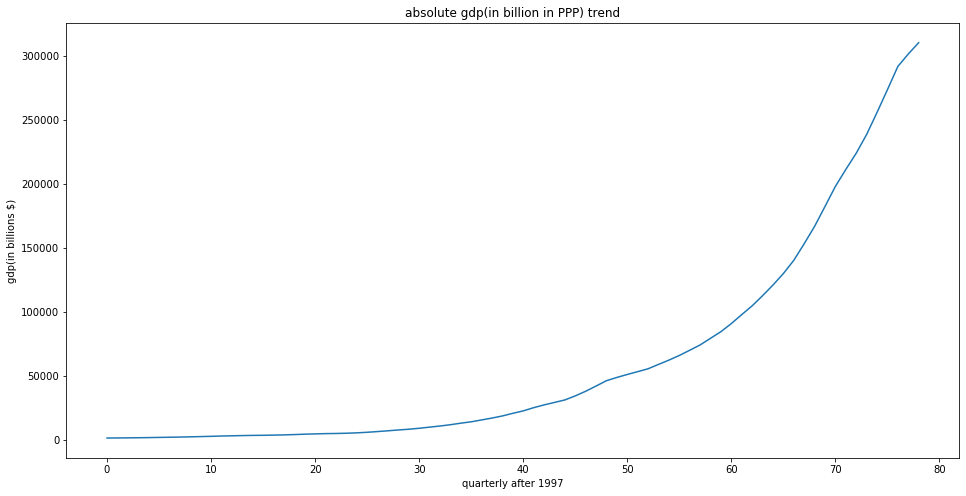

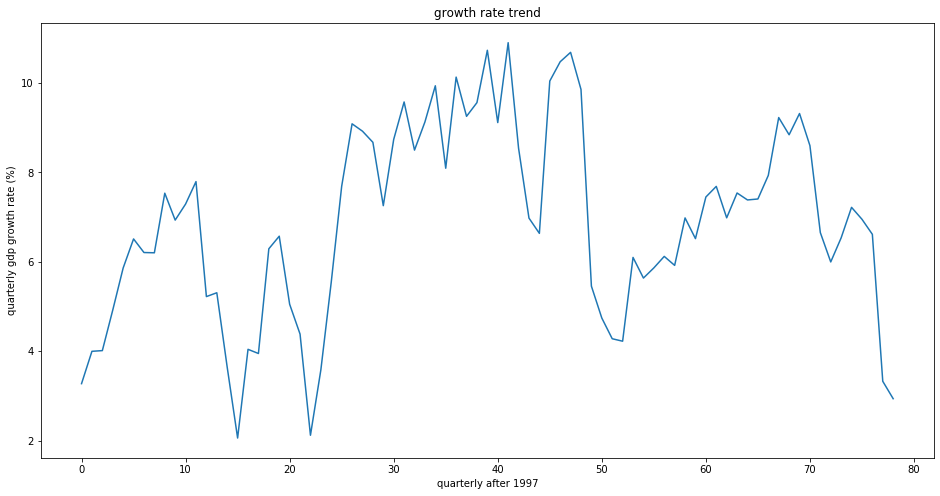

Correlation matrix
###################################

[[78.         77.05184821 77.35973036 75.81711702 77.25098961 77.71226875
  77.09415306]
 [77.05184821 78.         77.26769252 74.96631158 76.29455626 76.58050986
  75.63528248]
 [77.35973036 77.26769252 78.         75.78647669 77.58957055 77.47243256
  76.89862689]
 [75.81711702 74.96631158 75.78647669 78.         76.06695272 76.42148766
  76.52603076]
 [77.25098961 76.29455626 77.58957055 76.06695272 78.         77.72229871
  77.48651793]
 [77.71226875 76.58050986 77.47243256 76.42148766 77.72229871 78.
  77.74743034]
 [77.09415306 75.63528248 76.89862689 76.52603076 77.48651793 77.74743034
  78.        ]]
Adding Component No. 1
Information Retained =  98.71329779399687
[[ 0.33632382]
 [-0.15412367]
 [ 0.09104739]
 [-0.57426255]
 [-0.5793655 ]
 [-0.42582708]
 [ 0.08984428]]
Projected Data:
[[ 0.91795383]
 [ 0.91663305]
 [ 0.91158079]
 [ 0.88575096]
 [ 0.86683402]
 [ 0.88726745]
 [ 0.90373853]
 [ 0.87963289]
 [ 0.83792057]
 [ 0.8

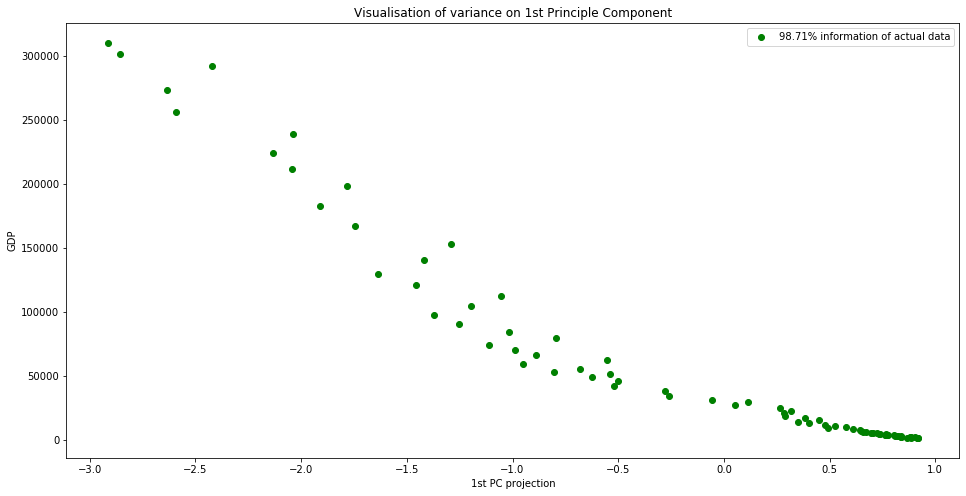

In [13]:
#
# Visualization of information in data
#

# calculation of absolute gdp after 19197 and its visulisation
gdp_actual_figure = 1653.1  # in billions$ in 1997 (PPP)
gdp_absolute = gdp.copy()

reference = gdp_actual_figure + gdp_actual_figure * gdp[0]/100

gdp_absolute[0] = reference

for i in range(len(gdp)-1):
    gdp_absolute[i+1] = reference + reference*gdp[i+1]/100
    reference = gdp_absolute[i+1]


fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(8)
plt.plot(gdp_absolute)
plt.title('absolute gdp(in billion in PPP) trend')
plt.xlabel('quarterly after 1997')
plt.ylabel('gdp(in billions $)')
plt.show()

fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(8)
plt.plot(gdp)
plt.title('growth rate trend')
plt.xlabel('quarterly after 1997')
plt.ylabel('quarterly gdp growth rate (%)')
plt.show()


visualisatio_using_pca(features, gdp_absolute)

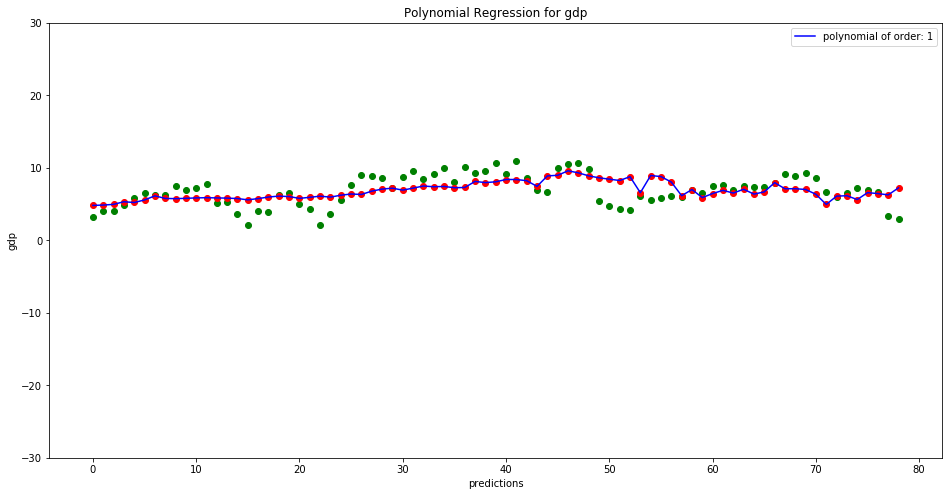

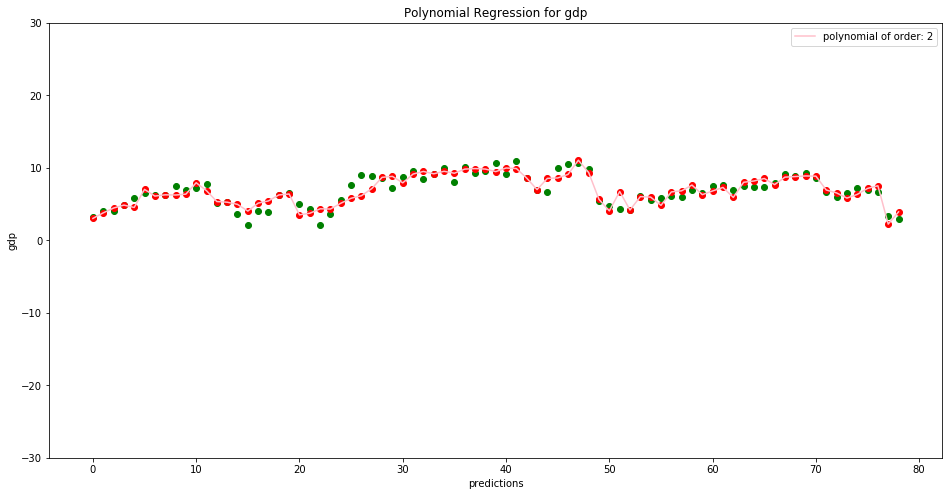

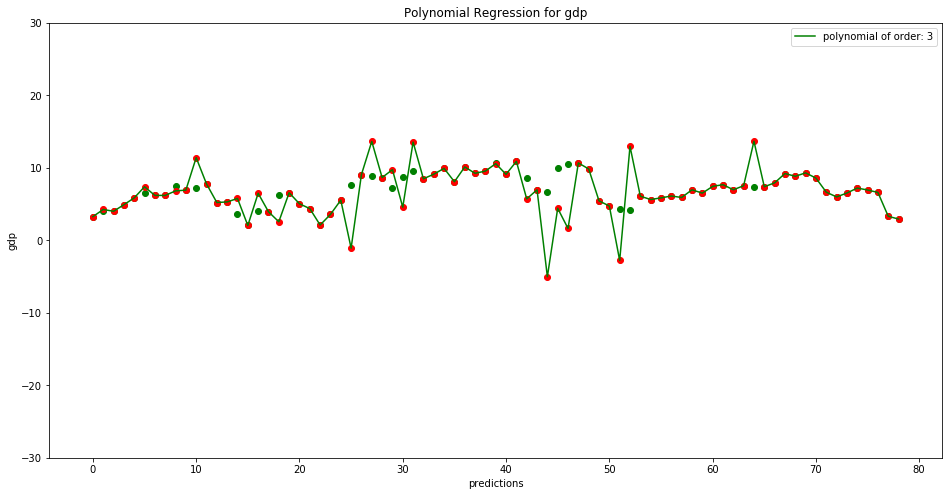

In [14]:
#
#  Modeling
#


colors = ['red', 'blue', 'pink', 'green', 'yellow']
for order in range(1,4):
    X = train_features
    y = train_res

    polynomial_model = PolynomialFeatures(degree=order)
    transformed_X = polynomial_model.fit_transform(X)
    polynomial_model.fit(transformed_X, y)
    regressor = LinearRegression()
    regressor.fit(transformed_X, y)

    output = regressor.predict(polynomial_model.fit_transform(features))

    x_axis = np.array([i for i in range(len(output))])

    
    fig = plt.figure()
    fig.set_figwidth(16)
    fig.set_figheight(8)
    plt.ylim([-30, 30])
    

    plt.scatter(x_axis, gdp, color = 'green')
    plt.scatter(x_axis, output, color = 'red')


    plt.plot(x_axis, regressor.predict(polynomial_model.fit_transform(features)), color = colors[order])
    
    plt.legend(['polynomial of order: '+ str(order)])

    plt.title('Polynomial Regression for gdp')
    plt.xlabel('predictions')
    plt.ylabel('gdp')
 
    plt.show()

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

In [16]:
polynomial_model = PolynomialFeatures(degree=2)
transformed_X = polynomial_model.fit_transform(X)
polynomial_model.fit(transformed_X, y)
regressor = LinearRegression()
regressor.fit(transformed_X, y)
score=regressor.score(transformed_X,y)
transformed_Xt=polynomial_model.fit_transform(test_features)
preds=regressor.predict(transformed_Xt)
r2=r2_score(test_res,preds)

scores = cross_val_score(regressor, X, y, cv =5)

print("Cross validation Result:")
print("%0.2f R2 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print("######################")


predict_train = regressor.predict(transformed_X)

mse_test = mean_squared_error(test_res,preds)
mae_test = mean_absolute_error(test_res,preds)

mse_train = mean_squared_error(train_res,predict_train)
mae_train = mean_absolute_error(train_res,predict_train)

print(f"The Mean squared error for test data for Polynomial Regression is {mse_test}")
print(f"The Mean absolute error for test data for Polynomial Regression is {mae_test}")


print(f"The Mean squared error for train data for Polynomial Regression is {mse_train}")
print(f"The Mean absolute error for train data for Polynomial Regression is {mae_train}")


print(f"The R2 score for train data for Polynomial Regression is {score}")
print(f"The R2 score for test data for Polynomial Regression is {r2}")


Cross validation Result:
-0.39 R2 with a standard deviation of 0.35
######################
The Mean squared error for test data for Polynomial Regression is 1.560846641118538
The Mean absolute error for test data for Polynomial Regression is 1.0443349774811275
The Mean squared error for train data for Polynomial Regression is 0.737413850595758
The Mean absolute error for train data for Polynomial Regression is 0.6469615285841238
The R2 score for train data for Polynomial Regression is 0.836033770870956
The R2 score for test data for Polynomial Regression is 0.6758887995550307


In [17]:
RFmodel=RandomForestRegressor(n_estimators=1000,max_depth=9)
RFmodel.fit(train_features,train_res)
score=RFmodel.score(train_features,train_res)
preds=RFmodel.predict(test_features)
r2=r2_score(test_res,preds)

scores = cross_val_score(RFmodel, X, y, cv=5)

print("Cross validation Result:")
print("%0.2f R2 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print("######################")
predict_train = RFmodel.predict(train_features)

mse_test = mean_squared_error(test_res,preds)
mae_test = mean_absolute_error(test_res,preds)

mse_train = mean_squared_error(train_res,predict_train)
mae_train = mean_absolute_error(train_res,predict_train)

print(f"The Mean squared error for test data for RandomForest Regression is {mse_test}")
print(f"The Mean absolute error for test data for RandomForest Regression is {mae_test}")


print(f"The Mean squared error for train data for RandomForest Regression is {mse_train}")
print(f"The Mean absolute error for train data for RandomForest Regression is {mae_train}")

print(f"The R2 score for train data for RandomForest Regression is {score}")
print(f"The R2 score for test data for RandomForest Regression is {r2}")

Cross validation Result:
0.20 R2 with a standard deviation of 0.22
######################
The Mean squared error for test data for RandomForest Regression is 1.8567848186202873
The Mean absolute error for test data for RandomForest Regression is 1.2030689571684416
The Mean squared error for train data for RandomForest Regression is 0.2553861907506514
The Mean absolute error for train data for RandomForest Regression is 0.3846015018401234
The R2 score for train data for RandomForest Regression is 0.9432140979787884
The R2 score for test data for RandomForest Regression is 0.6144369724243062


In [18]:
XGBmodel=XGBRegressor(n_estimators=1000)
XGBmodel.fit(train_features,train_res)
score=XGBmodel.score(train_features,train_res)
preds=XGBmodel.predict(test_features)
r2=r2_score(test_res,preds)

scores = cross_val_score(XGBmodel, X, y, cv=5)

print("Cross validation Result:")
print("%0.2f R2 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print("######################")

predict_train = XGBmodel.predict(train_features)

mse_test = mean_squared_error(test_res,preds)
mae_test = mean_absolute_error(test_res,preds)

mse_train = mean_squared_error(train_res,predict_train)
mae_train = mean_absolute_error(train_res,predict_train)

print(f"The Mean squared error for test data for XGBoost Regression is {mse_test}")
print(f"The Mean absolute error for test data for XGBoost Regression is {mae_test}")

print(f"The Mean squared error for train data for XGBoost Regression is {mse_train}")
print(f"The Mean absolute error for train data for XGBoost Regression is {mae_train}")

print(f"The R2 score for train data for XGBoost Regression is {score}")
print(f"The R2 score for test data for XGBoost Regression is {r2}")


Cross validation Result:
-0.05 R2 with a standard deviation of 0.51
######################
The Mean squared error for test data for XGBoost Regression is 2.1852072514141043
The Mean absolute error for test data for XGBoost Regression is 1.2235221133181327
The Mean squared error for train data for XGBoost Regression is 2.5445893962487704e-06
The Mean absolute error for train data for XGBoost Regression is 0.0011601373617700912
The R2 score for train data for XGBoost Regression is 0.9999994342027511
The R2 score for test data for XGBoost Regression is 0.5462397606408473
